In [1]:
from util.datagen import generator
from util.model import *
from cfg import *

import segmentation_models as sm
sm.set_framework('tf.keras')
import tensorflow.keras.backend as k
import gc

from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os, glob, datetime
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.figsize'] = (10,8)

Segmentation Models: using `keras` framework.
2 Physical GPUs, 2 Logical GPUs


In [28]:
DATA_SPLIT = [0.66,0.22,0.12]

In [29]:
ALL_SLIDE_PATHS = []; [ALL_SLIDE_PATHS.extend(glob.glob(path+'*.tiff')) for path in ALL_PATIENT_PATHS]
TRAIN_SLIDE_PATHS = shuffle(ALL_SLIDE_PATHS,random_state=123)[:int(DATA_SPLIT[0]*len(ALL_SLIDE_PATHS))]
VALID_SLIDE_PATHS = shuffle(ALL_SLIDE_PATHS,random_state=123)[int(DATA_SPLIT[0]*len(ALL_SLIDE_PATHS)):-int(DATA_SPLIT[2]*len(ALL_SLIDE_PATHS))]
TEST_SLIDE_PATHS = shuffle(ALL_SLIDE_PATHS,random_state=123)[-int(DATA_SPLIT[2]*len(ALL_SLIDE_PATHS)):]

TRAIN_ZIP = []
for path in TRAIN_SLIDE_PATHS:
    slide_name = path.split('/')[-1].replace('.tiff','').replace('.svs','')
    patient_path = '/'.join(path.split('/')[:-1]) + '/'
    for lbl in TRUE_LABEL_LIST :
        target_list = glob.glob(patient_path+f'{PATCH_NAME}/mask/{slide_name}*_p{lbl["label"]}.png')
        TRAIN_ZIP.extend(shuffle(target_list,random_state = 311)[:lbl["restrict"]])
    for lbl in ZERO_LABEL_LIST :
        target_list = glob.glob(patient_path+f'{PATCH_NAME}/mask/{slide_name}*_p{lbl["label"]}.png')
        TRAIN_ZIP.extend(shuffle(target_list,random_state = 311)[:lbl["restrict"]])
TRAIN_ZIP = shuffle([('/'.join(x.split('/')[:-2])+'/image/'+re.sub('_p[0-9]','',x.split('/')[-1]),x) for x in TRAIN_ZIP],random_state=311)

VALID_ZIP = []
for path in VALID_SLIDE_PATHS:
    slide_name = path.split('/')[-1].replace('.tiff','').replace('.svs','')
    patient_path = '/'.join(path.split('/')[:-1]) + '/'
    for lbl in TRUE_LABEL_LIST :
        target_list = glob.glob(patient_path+f'{PATCH_NAME}/mask/{slide_name}*_p{lbl["label"]}.png')
        VALID_ZIP.extend(shuffle(target_list,random_state = 311)[:lbl["restrict"]])
    for lbl in ZERO_LABEL_LIST :
        target_list = glob.glob(patient_path+f'{PATCH_NAME}/mask/{slide_name}*_p{lbl["label"]}.png')
        VALID_ZIP.extend(shuffle(target_list,random_state = 311)[:lbl["restrict"]])
VALID_ZIP = shuffle([('/'.join(x.split('/')[:-2])+'/image/'+re.sub('_p[0-9]','',x.split('/')[-1]),x) for x in VALID_ZIP],random_state=311)

TEST_ZIP = []
for path in TEST_SLIDE_PATHS:
    slide_name = path.split('/')[-1].replace('.tiff','').replace('.svs','')
    patient_path = '/'.join(path.split('/')[:-1]) + '/'
    
    for lbl in TRUE_LABEL_LIST :
        target_list = glob.glob(patient_path+f'{PATCH_NAME}/mask/{slide_name}*_p{lbl["label"]}.png')
        TEST_ZIP.extend(shuffle(target_list,random_state = 311)[:lbl["restrict"]])
    
    for lbl in ZERO_LABEL_LIST :
        target_list = glob.glob(patient_path+f'{PATCH_NAME}/mask/{slide_name}*_p{lbl["label"]}.png')
        TEST_ZIP.extend(shuffle(target_list,random_state = 311)[:lbl["restrict"]])
        
TEST_ZIP = shuffle([('/'.join(x.split('/')[:-2])+'/image/'+re.sub('_p[0-9]','',x.split('/')[-1]),x) for x in TEST_ZIP],random_state=311)

ZERO_LABELS = [x['label'] for x in ZERO_LABEL_LIST]


In [30]:
tr_1 = 0; tr_2 = 0; tr_3 = 0 ; tr_4 = 0
vl_1 = 0; vl_2 = 0; vl_3 = 0 ; vl_4 = 0
te_1 = 0; te_2 = 0; te_3 = 0 ; te_4 = 0

for tup in TRAIN_ZIP:
    x = tup[-1][-5]
    if x=='1':
        tr_1+=1
    elif x=='2':
        tr_2+=1
    elif x=='3':
        tr_3+=1
    else:
        tr_4+=1
print(f'TRAIN PATCH CLASS\nTUMOR : {tr_1 } NERVE : {tr_3+tr_2} NORMAL : {tr_4}')
for tup in VALID_ZIP:
    x = tup[-1][-5]
    if x=='1':
        vl_1+=1
    elif x=='2':
        vl_2+=1
    elif x=='3':
        vl_3+=1
    else:
        vl_4+=1
print(f'VALID PATCH CLASS\nTUMOR : {vl_1 } NERVE : {vl_2+vl_3} NORMAL : {vl_4}')
for tup in TEST_ZIP:
    x = tup[-1][-5]
    if x=='1':
        te_1+=1
    elif x=='2':
        te_2+=1
    elif x=='3':
        te_3+=1
    else:
        te_4+=1
print(f'TEST PATCH CLASS\nTUMOR : {te_1 } NERVE : {te_2+te_3} NORMAL : {te_4}')

TRAIN PATCH CLASS
TUMOR : 2426 NERVE : 672 NORMAL : 426
VALID PATCH CLASS
TUMOR : 858 NERVE : 228 NORMAL : 34
TEST PATCH CLASS
TUMOR : 430 NERVE : 104 NORMAL : 100


In [31]:
len(TRAIN_ZIP)

3524

In [74]:
class generator(tf.data.Dataset):
    
    # -----------------------------------------------
    # file_gen 은 img, mask path를 return하는 iterator
    # -----------------------------------------------
    def file_gen(zip_path_list):
        for zip_path in zip_path_list:
            img_path,mask_path = zip_path
            yield (img_path,mask_path)
    
    # ------------------------------------------------
    # map_func은 path로 부터 img를 load하는 map function
    # ------------------------------------------------
    def map_func(paths,zero_labels,is_train,binary):
        img_path = str(paths[0],'utf-8'); msk_path = str(paths[1],'utf-8')
        zero_labels = ['_p' + str(s) for s in zero_labels]
        img = cv.imread(img_path)
        
        if binary==True:
            if np.any([x in msk_path for x in zero_labels]):
                msk = np.zeros(img.shape[:2]).astype(np.float32)
            else:
                msk = cv.imread(msk_path,0).astype(np.float32)
        else:
            msk  = np.zeros(img.shape).astype(np.float32)
            if 'p1' in msk_path:
                msk[...,1] = cv.imread(msk_path,0).astype(np.float32)
            if 'p2' in msk_path or 'p3' in msk_path:
                msk[...,2] = cv.imread(msk_path,0).astype(np.float32)
            background = 1 - msk.sum(axis=-1, keepdims=True)
            msk[...,0] = np.squeeze(background)

        ## Augmentation
        def round_clip_0_1(x,**kwargs):
            return x.round().clip(0,1)
        if is_train==True:
            aug = Compose([
                HorizontalFlip(),
                HueSaturationValue(hue_shift_limit=5,sat_shift_limit=20,val_shift_limit=10,p=.9),
                VerticalFlip(),
                RandomRotate90(),
                ElasticTransform(),
                ToFloat(max_value=255,always_apply=True,p=1.0),
            ])
        else:
            aug = Compose([
                ToFloat(max_value=255,always_apply=True,p=1.0),
            ])
        pre_fn = Compose([
            Normalize(max_pixel_value = 1.0,always_apply=True,p=1.0)
            #Lambda(sm.get_preprocessing('efficientnetb0'))
        ])
        
        augmented = aug(image=img,mask=msk)
        augmented_img = augmented['image']
        augmented_mask = augmented['mask']
        augmented_img = pre_fn(image=augmented_img)

        return augmented_img['image'],augmented['mask']
    # ------------------------------------------------
    # class 호출하면 __new__로 dataset class 생성
    # ------------------------------------------------    
    
    # ------------------------------------------------
    # class 호출하면 __new__로 dataset class 생성
    # ------------------------------------------------    
    
    # ------------------------------------------------
    # class 호출하면 __new__로 dataset class 생성
    # ------------------------------------------------    
    def __new__(cls,zip_path_list,batch_size,zero_labels,is_train,binary):
        ret = tf.data.Dataset.from_generator(
            cls.file_gen,
            tf.string,
            output_shapes = tf.TensorShape([None]),
            args = (zip_path_list,)
        )
        ret = ret.map(
            lambda x : tf.numpy_function(
                cls.map_func,
                [x,zero_labels,is_train,binary],
                [tf.float32,tf.float32]
            ),num_parallel_calls = tf.data.experimental.AUTOTUNE
        )
        ret = ret.batch(batch_size,drop_remainder = True)
        ret = ret.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
        
        return ret


In [75]:
train_set = generator(TRAIN_ZIP,BATCH_SIZE,ZERO_LABELS,is_train=True,binary=False)
valid_set = generator(VALID_ZIP,BATCH_SIZE,ZERO_LABELS,is_train=True,binary=False)
test_set = generator(TEST_ZIP,BATCH_SIZE,ZERO_LABELS,is_train=True,binary=False)

### Visualization

In [37]:
from albumentations import *

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(32, 512, 512, 3) (32, 512, 512, 3)
2.535425
2.535425
2.6225712


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.64
2.64
2.2565577


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.64
2.4134207
2.3959913


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.5877128
2.6225712
2.6225712


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.517996
2.64


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.3262746
2.535425
2.5877128


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.5528543
2.5702832
2.6051416


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.5528543
2.6225712
2.5005665


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.517996
2.64
2.6051416


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.5005665
2.517996
2.6225712


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.5877128


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.5528543
2.6051416


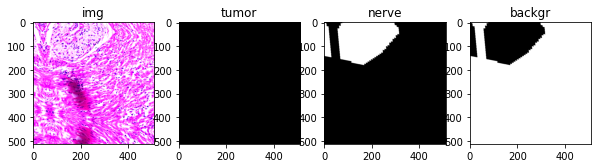

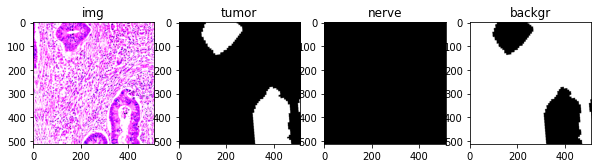

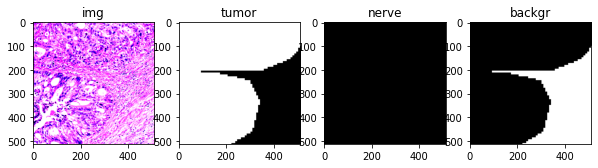

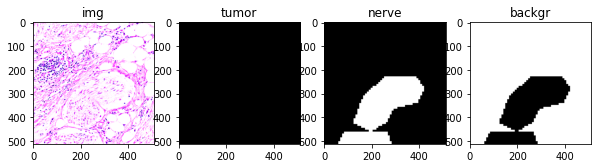

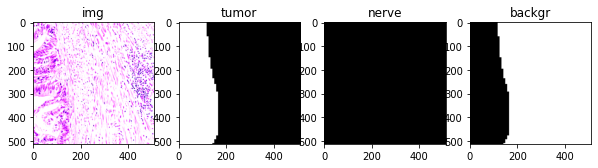

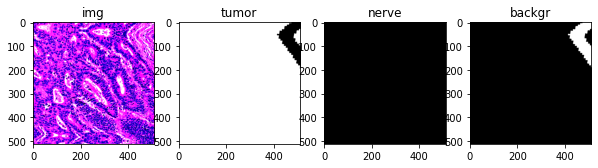

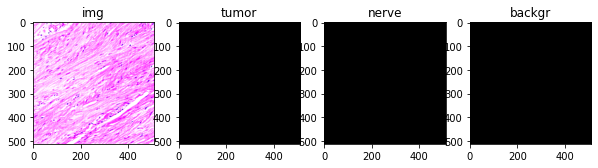

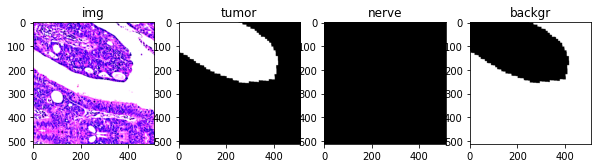

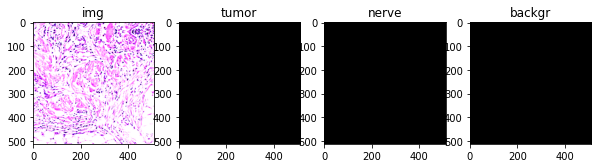

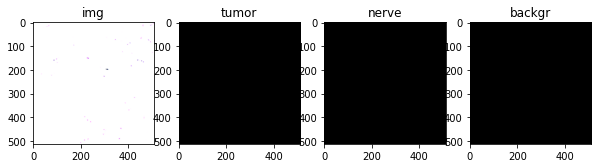

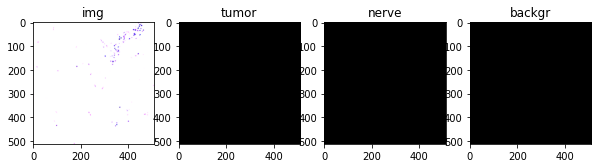

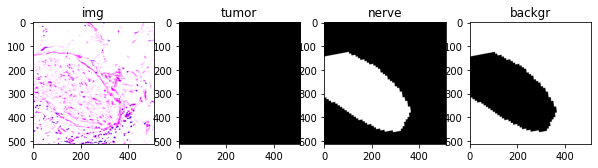

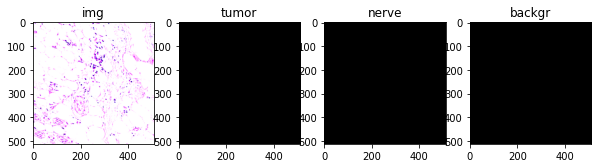

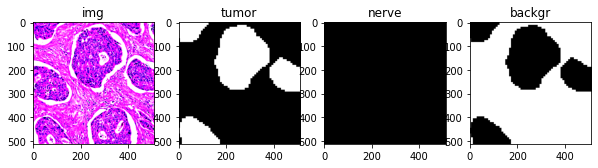

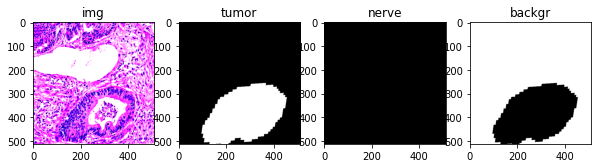

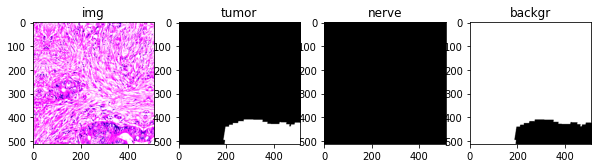

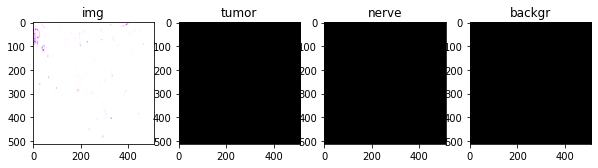

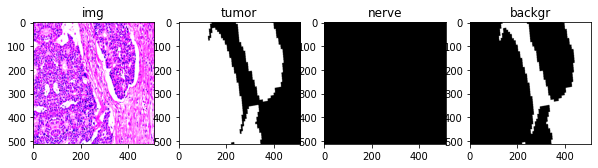

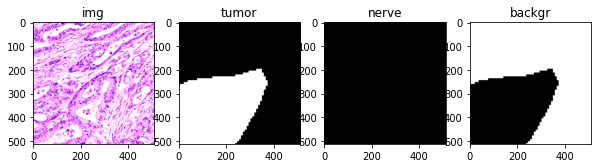

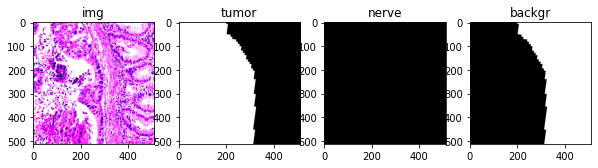

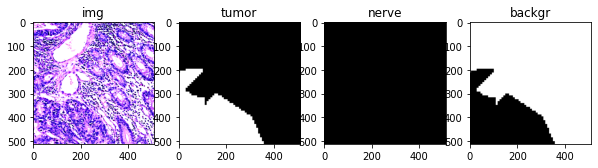

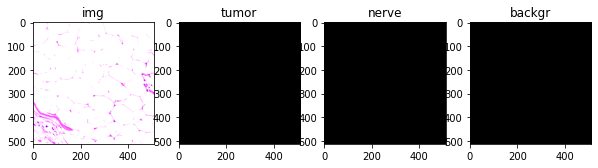

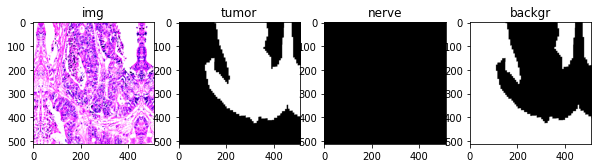

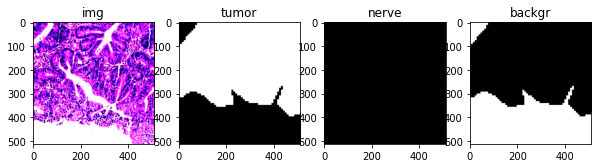

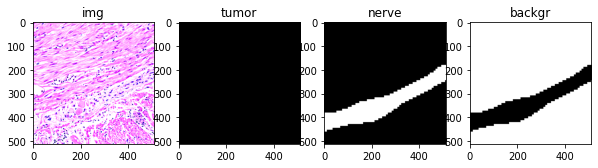

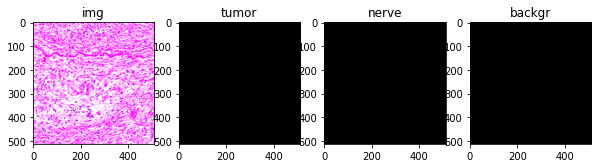

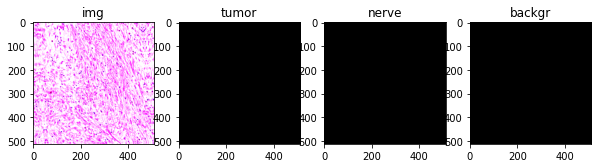

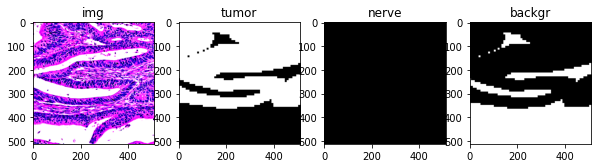

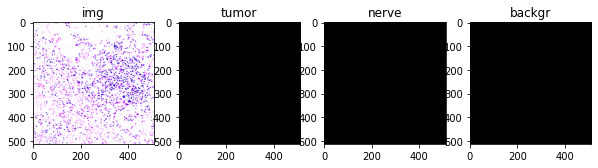

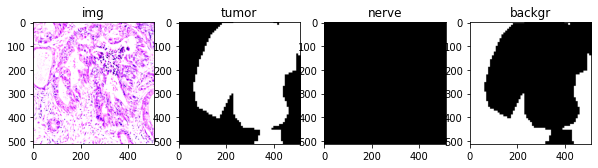

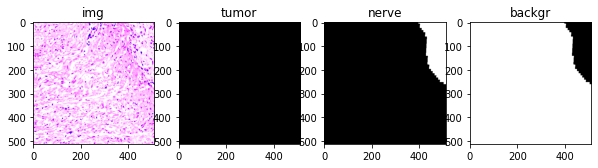

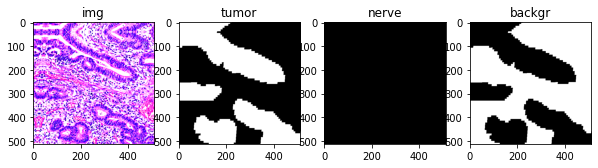

In [77]:
batch_set = next(iter(train_set))
img_batch , msk_batch = batch_set
print(img_batch.shape, msk_batch.shape)
for i in range(len(img_batch)):
    img = img_batch[i]
    print(np.max(img))
    msk = msk_batch[i]
    plt.figure()
    plt.subplot(1,4,1); plt.title('img'); plt.imshow(img)
    plt.subplot(1,4,2); plt.title('tumor'); plt.imshow(msk[...,1])
    plt.subplot(1,4,3); plt.title('nerve'); plt.imshow(msk[...,2])
    plt.subplot(1,4,4); plt.title('backgr'); plt.imshow(msk[...,0])

In [11]:
batch_set = train_set.take(1)

for img_batch,msk_batch in batch_set:
    for i in range(30):
        plt.figure()
        plt.subplot(1,4,1); plt.title('img') ; plt.imshow(img_batch[i])
        plt.subplot(1,4,2); plt.title('msk_tumor') ; plt.imshow(msk_batch[i][...,0])
        plt.subplot(1,4,3); plt.title('msk_nerve') ; plt.imshow(msk_batch[i][...,1])
        plt.subplot(1,4,4); plt.title('msk_backgr') ; plt.imshow(msk_batch[i][...,2])

ValueError: too many values to unpack (expected 2)

In [ ]:
batch_set = valid_set.take(18)
j = 0
for img_batch,msk_batch in batch_set:
    if j==17:
        for i in range(32):
            plt.figure()
            plt.subplot(1,2,1); plt.title('img') ; plt.imshow(img_batch[i])
            plt.subplot(1,2,2); plt.title('msk') ; plt.imshow(msk_batch[i])
    j+=1

---

### TRAIN BY FIT

In [78]:
print(INPUT_SHAPE)
print(EPOCHS)
print(PATIENCE)
print(MODEL_PATH) 
print(MODEL)
print(BACKBONE)
print(WEIGHT)
print(ACTIVATION)
print(INITIAL_LEARNING_RATE)
print(LOSS)
print(OPTIMIZER)
print(METRIC)

(512, 512, 3)
200
16
./model/0824_deeplabv3.hdf5
deeplab
xception
pascal_voc
sigmoid
0.01
dice+focal
adam
['iou', 'f1-score']


In [79]:
MODEL = 'unet'
TODAY = datetime.datetime.now().strftime('%m%d')
BACKBONE = 'efficientnetb0'
WEIGHT = 'imagenet'
LOSS = 'focal_dice'
N_CLASSES = 3

MODEL_PATH = os.path.join('./model/',(CLASS_NAME+'_'+str(MAGNIFICATION)+'_'+MODEL+'_'+BACKBONE+'_'+WEIGHT+'_'+TODAY+'norm.hdf5'))
print(MODEL_PATH)

./model/multi_100_unet_efficientnetb0_imagenet_0930norm.hdf5


In [80]:
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss(alpha=0.25, gamma=6.0)
class_weight = np.array([1,0.5,1]) # background tumor nerve  ordered
focal_loss = sm.losses.CategoricalFocalLoss(alpha = 0.25, gamma = 6.0)
loss = dice_loss + focal_loss
optim = Adam(INITIAL_LEARNING_RATE)
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), sm.metrics.Precision(), sm.metrics.Recall() ]

In [81]:
## MULTIGPU
import tensorflow as tf
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
with strategy.scope():
    model = build_seg_model(model = MODEL,backbone=BACKBONE,weight = WEIGHT,input_shape=INPUT_SHAPE,n_classes=N_CLASSES,activation='softmax')
    model.compile(optim, loss, metrics)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:

In [82]:
class LossAndErrorPrintingCallback(tf.keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        print("For batch {}, tr_loss is {:7.2f}.".format(batch, logs["loss"]))

    def on_test_batch_end(self, batch, logs=None):
        print("For batch {}, vl_loss is {:7.2f}.".format(batch, logs["loss"]))

    def on_epoch_end(self, epoch, logs=None):
        print(
            "The average loss for epoch {} is {:7.2f} "
            .format(
                epoch, logs["loss"]
            )
        )

In [83]:
#model.compile(optim, loss, metrics)
callback_list = build_callback(MODEL_PATH,PATIENCE)
callback_list.append(LossAndErrorPrintingCallback())

In [84]:
model.fit(train_set, 
          epochs = EPOCHS,
          batch_size=BATCH_SIZE,
          validation_data=valid_set,
          callbacks=callback_list,
          max_queue_size=36,
          workers=12,
          #use_multiprocessing=True,
          #verbose=1
         )

Epoch 1/200
INFO:tensorflow:batch_all_reduce: 130 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 130 all-reduces with algorithm = nccl, num_packs = 1
      1/Unknown - 53s 53s/step - loss: 0.8259 - iou_score: 0.0946 - f1-score: 0.1600 - precision: 0.3339 - recall: 0.3388For batch 0, tr_loss is    0.83.
      2/Unknown - 54s 555ms/step - loss: 0.7526 - iou_score: 0.1448 - f1-score: 0.2319 - precision: 0.3544 - recall: 0.3531For batch 1, tr_loss is    0.75.
      3/Unknown - 55s 667ms/step - loss: 0.7204 - iou_score: 0.1947 - f1-score: 0.2848 - precision: 0.3644 - recall: 0.3628For batch 2, tr_loss is    0.72.
      4/Unknown - 56s 840ms/step - loss: 0.6992 - iou_score: 0.2639 - f1-score: 0.3565 - precision: 0.3766 - recall: 0.4106For batch 3, tr_loss is    0.70.
      5/Unknown - 57s 885ms/step - loss: 0.6861 - iou_score: 0.2756 - f1-score: 0.3710 - precision: 0.3857 - recall: 0.4096For batch 4, tr_loss is    0.69.
      6/Unknown - 58s 923ms/step - l

    104/Unknown - 146s 902ms/step - loss: 0.3849 - iou_score: 0.5433 - f1-score: 0.6649 - precision: 0.6544 - recall: 0.6884For batch 103, tr_loss is    0.38.
    105/Unknown - 147s 896ms/step - loss: 0.3835 - iou_score: 0.5445 - f1-score: 0.6662 - precision: 0.6558 - recall: 0.6896For batch 104, tr_loss is    0.38.
    106/Unknown - 147s 891ms/step - loss: 0.3827 - iou_score: 0.5453 - f1-score: 0.6671 - precision: 0.6568 - recall: 0.6904For batch 105, tr_loss is    0.38.
    107/Unknown - 147s 886ms/step - loss: 0.3816 - iou_score: 0.5463 - f1-score: 0.6682 - precision: 0.6577 - recall: 0.6916For batch 106, tr_loss is    0.38.
    108/Unknown - 148s 881ms/step - loss: 0.3803 - iou_score: 0.5475 - f1-score: 0.6695 - precision: 0.6586 - recall: 0.6930For batch 107, tr_loss is    0.38.
    109/Unknown - 148s 876ms/step - loss: 0.3788 - iou_score: 0.5489 - f1-score: 0.6709 - precision: 0.6600 - recall: 0.6941For batch 108, tr_loss is    0.38.
    110/Unknown - 148s 871ms/step - loss: 0.37

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


The average loss for epoch 0 is    0.38 
Epoch 2/200
INFO:tensorflow:batch_all_reduce: 130 all-reduces with algorithm = nccl, num_packs = 1
 91/110 [=======================>......] - ETA: 18s - loss: 0.2482 - iou_score: 0.6787 - f1-score: 0.7997 - precision: 0.7793 - recall: 0.8125For batch 90, tr_loss is    0.25.


110/110 [==============================] - ETA: 0s - loss: 0.2486 - iou_score: 0.6780 - f1-score: 0.7988 - precision: 0.7796 - recall: 0.8129For batch 109, tr_loss is    0.25.
For batch 0, vl_loss is    0.52.
For batch 1, vl_loss is    0.43.
For batch 2, vl_loss is    0.45.
For batch 3, vl_loss is    0.41.
For batch 4, vl_loss is    0.41.
For batch 5, vl_loss is    0.42.
For batch 6, vl_loss is    0.41.
For batch 7, vl_loss is    0.41.
For batch 8, vl_loss is    0.41.
For batch 9, vl_loss is    0.41.
For batch 10, vl_loss is    0.40.
For batch 11, vl_loss is    0.39.
For batch 12, vl_loss is    0.40.
For batch 13, vl_loss is    0.39.
For batch 14, vl_loss is    0.40.
For batch 15, vl_loss is    0.40.
For batch 16, vl_loss is    0.41.
For batch 17, vl_loss is    0.41.
For batch 18, vl_loss is    0.41.
For batch 19, vl_loss is    0.40.
For batch 20, vl_loss is    0.40.
For batch 21, vl_loss is    0.39.
For batch 22, vl_loss is    0.39.
For batch 23, vl_loss is    0.39.
For batch 24, vl_l

110/110 [==============================] - ETA: 0s - loss: 0.2318 - iou_score: 0.6956 - f1-score: 0.8109 - precision: 0.7919 - recall: 0.8265For batch 109, tr_loss is    0.23.
For batch 0, vl_loss is    0.37.
For batch 1, vl_loss is    0.33.
For batch 2, vl_loss is    0.33.


For batch 3, vl_loss is    0.31.
For batch 4, vl_loss is    0.31.
For batch 5, vl_loss is    0.31.
For batch 6, vl_loss is    0.30.
For batch 7, vl_loss is    0.29.
For batch 8, vl_loss is    0.30.
For batch 9, vl_loss is    0.29.
For batch 10, vl_loss is    0.29.
For batch 11, vl_loss is    0.28.
For batch 12, vl_loss is    0.29.
For batch 13, vl_loss is    0.29.
For batch 14, vl_loss is    0.29.
For batch 15, vl_loss is    0.29.
For batch 16, vl_loss is    0.29.
For batch 17, vl_loss is    0.29.
For batch 18, vl_loss is    0.29.
For batch 19, vl_loss is    0.29.
For batch 20, vl_loss is    0.28.
For batch 21, vl_loss is    0.28.
For batch 22, vl_loss is    0.28.
For batch 23, vl_loss is    0.28.
For batch 24, vl_loss is    0.29.
For batch 25, vl_loss is    0.29.
For batch 26, vl_loss is    0.29.
For batch 27, vl_loss is    0.29.
For batch 28, vl_loss is    0.28.
For batch 29, vl_loss is    0.28.
For batch 30, vl_loss is    0.28.
For batch 31, vl_loss is    0.28.
For batch 32, vl_loss

110/110 [==============================] - ETA: 0s - loss: 0.2180 - iou_score: 0.7161 - f1-score: 0.8265 - precision: 0.8034 - recall: 0.8367For batch 109, tr_loss is    0.22.
For batch 0, vl_loss is    0.45.
For batch 1, vl_loss is    0.40.
For batch 2, vl_loss is    0.41.
For batch 3, vl_loss is    0.39.
For batch 4, vl_loss is    0.38.
For batch 5, vl_loss is    0.39.
For batch 6, vl_loss is    0.37.
For batch 7, vl_loss is    0.37.
For batch 8, vl_loss is    0.37.
For batch 9, vl_loss is    0.37.
For batch 10, vl_loss is    0.36.
For batch 11, vl_loss is    0.35.
For batch 12, vl_loss is    0.35.
For batch 13, vl_loss is    0.35.
For batch 14, vl_loss is    0.35.
For batch 15, vl_loss is    0.35.
For batch 16, vl_loss is    0.35.
For batch 17, vl_loss is    0.35.
For batch 18, vl_loss is    0.34.
For batch 19, vl_loss is    0.34.
For batch 20, vl_loss is    0.34.
For batch 21, vl_loss is    0.34.
For batch 22, vl_loss is    0.34.
For batch 23, vl_loss is    0.34.
For batch 24, vl_l

110/110 [==============================] - ETA: 0s - loss: 0.2093 - iou_score: 0.7228 - f1-score: 0.8305 - precision: 0.8114 - recall: 0.8427For batch 109, tr_loss is    0.21.
For batch 0, vl_loss is    0.31.
For batch 1, vl_loss is    0.26.
For batch 2, vl_loss is    0.29.
For batch 3, vl_loss is    0.27.
For batch 4, vl_loss is    0.26.
For batch 5, vl_loss is    0.26.
For batch 6, vl_loss is    0.25.
For batch 7, vl_loss is    0.25.
For batch 8, vl_loss is    0.25.
For batch 9, vl_loss is    0.25.
For batch 10, vl_loss is    0.25.
For batch 11, vl_loss is    0.24.
For batch 12, vl_loss is    0.25.
For batch 13, vl_loss is    0.25.
For batch 14, vl_loss is    0.24.
For batch 15, vl_loss is    0.25.
For batch 16, vl_loss is    0.25.
For batch 17, vl_loss is    0.25.
For batch 18, vl_loss is    0.25.
For batch 19, vl_loss is    0.24.
For batch 20, vl_loss is    0.24.
For batch 21, vl_loss is    0.24.
For batch 22, vl_loss is    0.24.
For batch 23, vl_loss is    0.24.
For batch 24, vl_l

110/110 [==============================] - ETA: 0s - loss: 0.2039 - iou_score: 0.7335 - f1-score: 0.8394 - precision: 0.8151 - recall: 0.8476For batch 109, tr_loss is    0.20.
For batch 0, vl_loss is    0.25.
For batch 1, vl_loss is    0.24.
For batch 2, vl_loss is    0.26.
For batch 3, vl_loss is    0.25.
For batch 4, vl_loss is    0.24.
For batch 5, vl_loss is    0.25.
For batch 6, vl_loss is    0.24.
For batch 7, vl_loss is    0.24.
For batch 8, vl_loss is    0.24.
For batch 9, vl_loss is    0.24.
For batch 10, vl_loss is    0.23.
For batch 11, vl_loss is    0.23.
For batch 12, vl_loss is    0.23.
For batch 13, vl_loss is    0.23.
For batch 14, vl_loss is    0.23.
For batch 15, vl_loss is    0.23.
For batch 16, vl_loss is    0.23.
For batch 17, vl_loss is    0.23.
For batch 18, vl_loss is    0.23.
For batch 19, vl_loss is    0.23.
For batch 20, vl_loss is    0.22.
For batch 21, vl_loss is    0.22.
For batch 22, vl_loss is    0.22.
For batch 23, vl_loss is    0.22.
For batch 24, vl_l

 94/110 [========================>.....] - ETA: 14s - loss: 0.2003 - iou_score: 0.7324 - f1-score: 0.8370 - precision: 0.8165 - recall: 0.8513For batch 93, tr_loss is    0.20.


110/110 [==============================] - ETA: 0s - loss: 0.1996 - iou_score: 0.7330 - f1-score: 0.8375 - precision: 0.8173 - recall: 0.8515For batch 109, tr_loss is    0.20.
For batch 0, vl_loss is    0.30.
For batch 1, vl_loss is    0.27.
For batch 2, vl_loss is    0.28.
For batch 3, vl_loss is    0.27.
For batch 4, vl_loss is    0.26.
For batch 5, vl_loss is    0.27.
For batch 6, vl_loss is    0.26.
For batch 7, vl_loss is    0.26.
For batch 8, vl_loss is    0.26.
For batch 9, vl_loss is    0.26.
For batch 10, vl_loss is    0.25.
For batch 11, vl_loss is    0.25.
For batch 12, vl_loss is    0.25.
For batch 13, vl_loss is    0.25.
For batch 14, vl_loss is    0.25.
For batch 15, vl_loss is    0.25.
For batch 16, vl_loss is    0.25.
For batch 17, vl_loss is    0.25.
For batch 18, vl_loss is    0.26.
For batch 19, vl_loss is    0.25.
For batch 20, vl_loss is    0.25.
For batch 21, vl_loss is    0.25.
For batch 22, vl_loss is    0.25.
For batch 23, vl_loss is    0.25.
For batch 24, vl_l

110/110 [==============================] - ETA: 0s - loss: 0.1974 - iou_score: 0.7375 - f1-score: 0.8410 - precision: 0.8194 - recall: 0.8528For batch 109, tr_loss is    0.20.
For batch 0, vl_loss is    0.33.
For batch 1, vl_loss is    0.29.
For batch 2, vl_loss is    0.30.
For batch 3, vl_loss is    0.28.
For batch 4, vl_loss is    0.28.
For batch 5, vl_loss is    0.28.
For batch 6, vl_loss is    0.26.
For batch 7, vl_loss is    0.26.
For batch 8, vl_loss is    0.26.
For batch 9, vl_loss is    0.26.
For batch 10, vl_loss is    0.25.
For batch 11, vl_loss is    0.25.
For batch 12, vl_loss is    0.26.
For batch 13, vl_loss is    0.26.
For batch 14, vl_loss is    0.26.
For batch 15, vl_loss is    0.26.
For batch 16, vl_loss is    0.26.
For batch 17, vl_loss is    0.26.
For batch 18, vl_loss is    0.26.


For batch 19, vl_loss is    0.25.
For batch 20, vl_loss is    0.25.
For batch 21, vl_loss is    0.25.
For batch 22, vl_loss is    0.25.
For batch 23, vl_loss is    0.25.
For batch 24, vl_loss is    0.25.
For batch 25, vl_loss is    0.25.
For batch 26, vl_loss is    0.25.
For batch 27, vl_loss is    0.25.
For batch 28, vl_loss is    0.25.
For batch 29, vl_loss is    0.25.
For batch 30, vl_loss is    0.25.
For batch 31, vl_loss is    0.25.
For batch 32, vl_loss is    0.25.
For batch 33, vl_loss is    0.25.
For batch 34, vl_loss is    0.25.
110/110 [==============================] - 130s 1s/step - loss: 0.1974 - iou_score: 0.7375 - f1-score: 0.8410 - precision: 0.8194 - recall: 0.8528 - val_loss: 0.2462 - val_iou_score: 0.6802 - val_f1-score: 0.8014 - val_precision: 0.7936 - val_recall: 0.7883

Epoch 00008: val_loss did not improve from 0.22458
The average loss for epoch 7 is    0.20 
Epoch 9/200
 87/110 [======================>.......] - ETA: 22s - loss: 0.1916 - iou_score: 0.7431 - f1-s

110/110 [==============================] - ETA: 0s - loss: 0.1915 - iou_score: 0.7442 - f1-score: 0.8457 - precision: 0.8249 - recall: 0.8565For batch 109, tr_loss is    0.19.
For batch 0, vl_loss is    0.35.
For batch 1, vl_loss is    0.34.
For batch 2, vl_loss is    0.33.
For batch 3, vl_loss is    0.31.
For batch 4, vl_loss is    0.30.
For batch 5, vl_loss is    0.31.
For batch 6, vl_loss is    0.31.
For batch 7, vl_loss is    0.30.
For batch 8, vl_loss is    0.31.
For batch 9, vl_loss is    0.30.
For batch 10, vl_loss is    0.30.
For batch 11, vl_loss is    0.30.
For batch 12, vl_loss is    0.30.
For batch 13, vl_loss is    0.30.
For batch 14, vl_loss is    0.30.
For batch 15, vl_loss is    0.30.
For batch 16, vl_loss is    0.30.
For batch 17, vl_loss is    0.30.
For batch 18, vl_loss is    0.30.
For batch 19, vl_loss is    0.29.
For batch 20, vl_loss is    0.29.
For batch 21, vl_loss is    0.29.
For batch 22, vl_loss is    0.29.
For batch 23, vl_loss is    0.29.
For batch 24, vl_l

110/110 [==============================] - ETA: 0s - loss: 0.1892 - iou_score: 0.7478 - f1-score: 0.8485 - precision: 0.8262 - recall: 0.8590For batch 109, tr_loss is    0.19.
For batch 0, vl_loss is    0.33.
For batch 1, vl_loss is    0.31.
For batch 2, vl_loss is    0.30.
For batch 3, vl_loss is    0.28.
For batch 4, vl_loss is    0.27.
For batch 5, vl_loss is    0.28.
For batch 6, vl_loss is    0.27.
For batch 7, vl_loss is    0.26.
For batch 8, vl_loss is    0.26.
For batch 9, vl_loss is    0.26.
For batch 10, vl_loss is    0.26.
For batch 11, vl_loss is    0.25.
For batch 12, vl_loss is    0.26.
For batch 13, vl_loss is    0.26.
For batch 14, vl_loss is    0.26.
For batch 15, vl_loss is    0.26.
For batch 16, vl_loss is    0.26.
For batch 17, vl_loss is    0.26.
For batch 18, vl_loss is    0.26.
For batch 19, vl_loss is    0.26.
For batch 20, vl_loss is    0.25.
For batch 21, vl_loss is    0.25.
For batch 22, vl_loss is    0.25.
For batch 23, vl_loss is    0.25.
For batch 24, vl_l

110/110 [==============================] - ETA: 0s - loss: 0.1847 - iou_score: 0.7549 - f1-score: 0.8539 - precision: 0.8304 - recall: 0.8624For batch 109, tr_loss is    0.18.
For batch 0, vl_loss is    0.41.
For batch 1, vl_loss is    0.34.
For batch 2, vl_loss is    0.36.
For batch 3, vl_loss is    0.34.
For batch 4, vl_loss is    0.34.
For batch 5, vl_loss is    0.36.
For batch 6, vl_loss is    0.34.
For batch 7, vl_loss is    0.34.
For batch 8, vl_loss is    0.34.
For batch 9, vl_loss is    0.35.
For batch 10, vl_loss is    0.34.
For batch 11, vl_loss is    0.33.
For batch 12, vl_loss is    0.34.
For batch 13, vl_loss is    0.33.
For batch 14, vl_loss is    0.33.
For batch 15, vl_loss is    0.34.
For batch 16, vl_loss is    0.34.
For batch 17, vl_loss is    0.34.
For batch 18, vl_loss is    0.34.
For batch 19, vl_loss is    0.33.
For batch 20, vl_loss is    0.33.
For batch 21, vl_loss is    0.33.
For batch 22, vl_loss is    0.33.
For batch 23, vl_loss is    0.33.
For batch 24, vl_l

 98/110 [=========================>....] - ETA: 11s - loss: 0.1877 - iou_score: 0.7493 - f1-score: 0.8490 - precision: 0.8273 - recall: 0.8611For batch 97, tr_loss is    0.19.


110/110 [==============================] - ETA: 0s - loss: 0.1888 - iou_score: 0.7488 - f1-score: 0.8491 - precision: 0.8275 - recall: 0.8592For batch 109, tr_loss is    0.19.
For batch 0, vl_loss is    0.35.
For batch 1, vl_loss is    0.31.
For batch 2, vl_loss is    0.32.
For batch 3, vl_loss is    0.31.
For batch 4, vl_loss is    0.32.
For batch 5, vl_loss is    0.34.
For batch 6, vl_loss is    0.32.
For batch 7, vl_loss is    0.32.
For batch 8, vl_loss is    0.32.
For batch 9, vl_loss is    0.32.
For batch 10, vl_loss is    0.31.
For batch 11, vl_loss is    0.31.
For batch 12, vl_loss is    0.31.
For batch 13, vl_loss is    0.31.
For batch 14, vl_loss is    0.31.
For batch 15, vl_loss is    0.31.
For batch 16, vl_loss is    0.31.
For batch 17, vl_loss is    0.31.
For batch 18, vl_loss is    0.31.
For batch 19, vl_loss is    0.31.
For batch 20, vl_loss is    0.30.
For batch 21, vl_loss is    0.30.
For batch 22, vl_loss is    0.30.
For batch 23, vl_loss is    0.30.
For batch 24, vl_l

110/110 [==============================] - ETA: 0s - loss: 0.1842 - iou_score: 0.7529 - f1-score: 0.8513 - precision: 0.8301 - recall: 0.8634For batch 109, tr_loss is    0.18.
For batch 0, vl_loss is    0.33.
For batch 1, vl_loss is    0.28.
For batch 2, vl_loss is    0.28.
For batch 3, vl_loss is    0.26.
For batch 4, vl_loss is    0.26.
For batch 5, vl_loss is    0.27.
For batch 6, vl_loss is    0.26.
For batch 7, vl_loss is    0.26.
For batch 8, vl_loss is    0.26.
For batch 9, vl_loss is    0.25.
For batch 10, vl_loss is    0.25.
For batch 11, vl_loss is    0.24.
For batch 12, vl_loss is    0.24.
For batch 13, vl_loss is    0.24.
For batch 14, vl_loss is    0.24.
For batch 15, vl_loss is    0.24.
For batch 16, vl_loss is    0.24.
For batch 17, vl_loss is    0.24.
For batch 18, vl_loss is    0.24.
For batch 19, vl_loss is    0.24.
For batch 20, vl_loss is    0.24.
For batch 21, vl_loss is    0.24.
For batch 22, vl_loss is    0.24.
For batch 23, vl_loss is    0.24.
For batch 24, vl_l


Epoch 00013: val_loss did not improve from 0.22458
The average loss for epoch 12 is    0.18 
Epoch 14/200
 91/110 [=======================>......] - ETA: 18s - loss: 0.1769 - iou_score: 0.7657 - f1-score: 0.8616 - precision: 0.8377 - recall: 0.8662For batch 90, tr_loss is    0.18.


110/110 [==============================] - ETA: 0s - loss: 0.1781 - iou_score: 0.7633 - f1-score: 0.8592 - precision: 0.8363 - recall: 0.8673For batch 109, tr_loss is    0.18.
For batch 0, vl_loss is    0.31.
For batch 1, vl_loss is    0.29.
For batch 2, vl_loss is    0.30.
For batch 3, vl_loss is    0.29.
For batch 4, vl_loss is    0.28.
For batch 5, vl_loss is    0.29.
For batch 6, vl_loss is    0.28.
For batch 7, vl_loss is    0.28.
For batch 8, vl_loss is    0.28.
For batch 9, vl_loss is    0.28.
For batch 10, vl_loss is    0.29.
For batch 11, vl_loss is    0.29.
For batch 12, vl_loss is    0.29.
For batch 13, vl_loss is    0.29.
For batch 14, vl_loss is    0.28.
For batch 15, vl_loss is    0.28.
For batch 16, vl_loss is    0.28.
For batch 17, vl_loss is    0.28.
For batch 18, vl_loss is    0.29.
For batch 19, vl_loss is    0.29.
For batch 20, vl_loss is    0.29.
For batch 21, vl_loss is    0.28.
For batch 22, vl_loss is    0.28.
For batch 23, vl_loss is    0.28.
For batch 24, vl_l

110/110 [==============================] - ETA: 0s - loss: 0.1723 - iou_score: 0.7725 - f1-score: 0.8659 - precision: 0.8412 - recall: 0.8723For batch 109, tr_loss is    0.17.
For batch 0, vl_loss is    0.30.
For batch 1, vl_loss is    0.27.
For batch 2, vl_loss is    0.28.


For batch 3, vl_loss is    0.26.
For batch 4, vl_loss is    0.25.
For batch 5, vl_loss is    0.26.
For batch 6, vl_loss is    0.25.
For batch 7, vl_loss is    0.24.
For batch 8, vl_loss is    0.24.
For batch 9, vl_loss is    0.24.
For batch 10, vl_loss is    0.24.
For batch 11, vl_loss is    0.24.
For batch 12, vl_loss is    0.24.
For batch 13, vl_loss is    0.24.
For batch 14, vl_loss is    0.23.
For batch 15, vl_loss is    0.24.
For batch 16, vl_loss is    0.23.
For batch 17, vl_loss is    0.23.
For batch 18, vl_loss is    0.23.
For batch 19, vl_loss is    0.23.
For batch 20, vl_loss is    0.23.
For batch 21, vl_loss is    0.23.
For batch 22, vl_loss is    0.23.
For batch 23, vl_loss is    0.23.
For batch 24, vl_loss is    0.23.
For batch 25, vl_loss is    0.23.
For batch 26, vl_loss is    0.23.
For batch 27, vl_loss is    0.23.
For batch 28, vl_loss is    0.23.
For batch 29, vl_loss is    0.23.
For batch 30, vl_loss is    0.23.
For batch 31, vl_loss is    0.23.
For batch 32, vl_loss

110/110 [==============================] - ETA: 0s - loss: 0.1692 - iou_score: 0.7797 - f1-score: 0.8722 - precision: 0.8447 - recall: 0.8730For batch 109, tr_loss is    0.17.
For batch 0, vl_loss is    0.29.
For batch 1, vl_loss is    0.25.
For batch 2, vl_loss is    0.27.
For batch 3, vl_loss is    0.25.
For batch 4, vl_loss is    0.24.
For batch 5, vl_loss is    0.25.
For batch 6, vl_loss is    0.24.
For batch 7, vl_loss is    0.23.
For batch 8, vl_loss is    0.23.
For batch 9, vl_loss is    0.23.
For batch 10, vl_loss is    0.23.
For batch 11, vl_loss is    0.22.
For batch 12, vl_loss is    0.22.
For batch 13, vl_loss is    0.22.
For batch 14, vl_loss is    0.22.
For batch 15, vl_loss is    0.22.
For batch 16, vl_loss is    0.22.
For batch 17, vl_loss is    0.22.
For batch 18, vl_loss is    0.22.
For batch 19, vl_loss is    0.22.
For batch 20, vl_loss is    0.22.
For batch 21, vl_loss is    0.21.
For batch 22, vl_loss is    0.21.
For batch 23, vl_loss is    0.21.
For batch 24, vl_l

110/110 [==============================] - ETA: 0s - loss: 0.1662 - iou_score: 0.7793 - f1-score: 0.8703 - precision: 0.8468 - recall: 0.8756For batch 109, tr_loss is    0.17.
For batch 0, vl_loss is    0.25.
For batch 1, vl_loss is    0.24.
For batch 2, vl_loss is    0.25.
For batch 3, vl_loss is    0.24.
For batch 4, vl_loss is    0.23.
For batch 5, vl_loss is    0.24.
For batch 6, vl_loss is    0.23.
For batch 7, vl_loss is    0.23.
For batch 8, vl_loss is    0.23.
For batch 9, vl_loss is    0.23.
For batch 10, vl_loss is    0.22.
For batch 11, vl_loss is    0.22.
For batch 12, vl_loss is    0.22.
For batch 13, vl_loss is    0.22.
For batch 14, vl_loss is    0.22.
For batch 15, vl_loss is    0.22.
For batch 16, vl_loss is    0.22.
For batch 17, vl_loss is    0.22.
For batch 18, vl_loss is    0.22.
For batch 19, vl_loss is    0.22.
For batch 20, vl_loss is    0.21.
For batch 21, vl_loss is    0.21.
For batch 22, vl_loss is    0.21.
For batch 23, vl_loss is    0.21.
For batch 24, vl_l

110/110 [==============================] - ETA: 0s - loss: 0.1647 - iou_score: 0.7800 - f1-score: 0.8703 - precision: 0.8485 - recall: 0.8772For batch 109, tr_loss is    0.16.
For batch 0, vl_loss is    0.24.
For batch 1, vl_loss is    0.23.
For batch 2, vl_loss is    0.24.
For batch 3, vl_loss is    0.23.
For batch 4, vl_loss is    0.23.
For batch 5, vl_loss is    0.25.
For batch 6, vl_loss is    0.24.
For batch 7, vl_loss is    0.23.
For batch 8, vl_loss is    0.23.
For batch 9, vl_loss is    0.23.
For batch 10, vl_loss is    0.23.
For batch 11, vl_loss is    0.22.
For batch 12, vl_loss is    0.22.
For batch 13, vl_loss is    0.22.
For batch 14, vl_loss is    0.22.
For batch 15, vl_loss is    0.22.
For batch 16, vl_loss is    0.22.
For batch 17, vl_loss is    0.22.
For batch 18, vl_loss is    0.23.
For batch 19, vl_loss is    0.22.
For batch 20, vl_loss is    0.22.
For batch 21, vl_loss is    0.22.
For batch 22, vl_loss is    0.22.
For batch 23, vl_loss is    0.22.
For batch 24, vl_l

 95/110 [========================>.....] - ETA: 14s - loss: 0.1650 - iou_score: 0.7793 - f1-score: 0.8694 - precision: 0.8482 - recall: 0.8777For batch 94, tr_loss is    0.16.


110/110 [==============================] - ETA: 0s - loss: 0.1650 - iou_score: 0.7784 - f1-score: 0.8686 - precision: 0.8484 - recall: 0.8773For batch 109, tr_loss is    0.16.
For batch 0, vl_loss is    0.27.
For batch 1, vl_loss is    0.26.
For batch 2, vl_loss is    0.25.
For batch 3, vl_loss is    0.24.
For batch 4, vl_loss is    0.24.
For batch 5, vl_loss is    0.24.
For batch 6, vl_loss is    0.23.
For batch 7, vl_loss is    0.23.
For batch 8, vl_loss is    0.23.
For batch 9, vl_loss is    0.23.
For batch 10, vl_loss is    0.23.
For batch 11, vl_loss is    0.23.
For batch 12, vl_loss is    0.23.
For batch 13, vl_loss is    0.23.
For batch 14, vl_loss is    0.23.
For batch 15, vl_loss is    0.23.
For batch 16, vl_loss is    0.23.
For batch 17, vl_loss is    0.23.
For batch 18, vl_loss is    0.23.
For batch 19, vl_loss is    0.23.
For batch 20, vl_loss is    0.23.
For batch 21, vl_loss is    0.23.
For batch 22, vl_loss is    0.22.
For batch 23, vl_loss is    0.22.
For batch 24, vl_l

110/110 [==============================] - ETA: 0s - loss: 0.1622 - iou_score: 0.7873 - f1-score: 0.8767 - precision: 0.8500 - recall: 0.8793For batch 109, tr_loss is    0.16.
For batch 0, vl_loss is    0.29.
For batch 1, vl_loss is    0.26.
For batch 2, vl_loss is    0.26.
For batch 3, vl_loss is    0.24.
For batch 4, vl_loss is    0.24.
For batch 5, vl_loss is    0.24.
For batch 6, vl_loss is    0.23.
For batch 7, vl_loss is    0.23.
For batch 8, vl_loss is    0.23.
For batch 9, vl_loss is    0.22.
For batch 10, vl_loss is    0.22.
For batch 11, vl_loss is    0.22.
For batch 12, vl_loss is    0.22.
For batch 13, vl_loss is    0.22.
For batch 14, vl_loss is    0.22.
For batch 15, vl_loss is    0.22.
For batch 16, vl_loss is    0.22.
For batch 17, vl_loss is    0.22.
For batch 18, vl_loss is    0.22.
For batch 19, vl_loss is    0.22.
For batch 20, vl_loss is    0.22.
For batch 21, vl_loss is    0.22.
For batch 22, vl_loss is    0.21.
For batch 23, vl_loss is    0.22.


For batch 24, vl_loss is    0.22.
For batch 25, vl_loss is    0.22.
For batch 26, vl_loss is    0.22.
For batch 27, vl_loss is    0.22.
For batch 28, vl_loss is    0.22.
For batch 29, vl_loss is    0.22.
For batch 30, vl_loss is    0.22.
For batch 31, vl_loss is    0.22.
For batch 32, vl_loss is    0.22.
For batch 33, vl_loss is    0.22.
For batch 34, vl_loss is    0.22.
110/110 [==============================] - 129s 1s/step - loss: 0.1622 - iou_score: 0.7873 - f1-score: 0.8767 - precision: 0.8500 - recall: 0.8793 - val_loss: 0.2167 - val_iou_score: 0.7191 - val_f1-score: 0.8295 - val_precision: 0.8146 - val_recall: 0.8249

Epoch 00020: val_loss did not improve from 0.21364
The average loss for epoch 19 is    0.16 
Epoch 21/200
 88/110 [=======================>......] - ETA: 21s - loss: 0.1626 - iou_score: 0.7836 - f1-score: 0.8732 - precision: 0.8492 - recall: 0.8788For batch 87, tr_loss is    0.16.


110/110 [==============================] - ETA: 0s - loss: 0.1626 - iou_score: 0.7837 - f1-score: 0.8732 - precision: 0.8494 - recall: 0.8795For batch 109, tr_loss is    0.16.
For batch 0, vl_loss is    0.24.
For batch 1, vl_loss is    0.24.
For batch 2, vl_loss is    0.25.
For batch 3, vl_loss is    0.24.
For batch 4, vl_loss is    0.23.
For batch 5, vl_loss is    0.25.
For batch 6, vl_loss is    0.23.
For batch 7, vl_loss is    0.23.
For batch 8, vl_loss is    0.23.
For batch 9, vl_loss is    0.23.
For batch 10, vl_loss is    0.23.
For batch 11, vl_loss is    0.23.
For batch 12, vl_loss is    0.23.
For batch 13, vl_loss is    0.23.
For batch 14, vl_loss is    0.22.
For batch 15, vl_loss is    0.23.
For batch 16, vl_loss is    0.23.
For batch 17, vl_loss is    0.23.
For batch 18, vl_loss is    0.23.
For batch 19, vl_loss is    0.23.
For batch 20, vl_loss is    0.23.
For batch 21, vl_loss is    0.22.
For batch 22, vl_loss is    0.22.
For batch 23, vl_loss is    0.22.
For batch 24, vl_l

110/110 [==============================] - ETA: 0s - loss: 0.1582 - iou_score: 0.7928 - f1-score: 0.8802 - precision: 0.8541 - recall: 0.8821For batch 109, tr_loss is    0.16.
For batch 0, vl_loss is    0.28.
For batch 1, vl_loss is    0.26.
For batch 2, vl_loss is    0.27.
For batch 3, vl_loss is    0.26.
For batch 4, vl_loss is    0.25.
For batch 5, vl_loss is    0.25.
For batch 6, vl_loss is    0.25.
For batch 7, vl_loss is    0.25.
For batch 8, vl_loss is    0.24.
For batch 9, vl_loss is    0.24.
For batch 10, vl_loss is    0.25.
For batch 11, vl_loss is    0.25.
For batch 12, vl_loss is    0.25.
For batch 13, vl_loss is    0.25.
For batch 14, vl_loss is    0.25.
For batch 15, vl_loss is    0.25.
For batch 16, vl_loss is    0.25.
For batch 17, vl_loss is    0.25.
For batch 18, vl_loss is    0.25.
For batch 19, vl_loss is    0.25.
For batch 20, vl_loss is    0.25.
For batch 21, vl_loss is    0.25.
For batch 22, vl_loss is    0.25.
For batch 23, vl_loss is    0.25.
For batch 24, vl_l

110/110 [==============================] - ETA: 0s - loss: 0.1604 - iou_score: 0.7841 - f1-score: 0.8724 - precision: 0.8527 - recall: 0.8805For batch 109, tr_loss is    0.16.
For batch 0, vl_loss is    0.29.
For batch 1, vl_loss is    0.26.
For batch 2, vl_loss is    0.27.
For batch 3, vl_loss is    0.26.
For batch 4, vl_loss is    0.25.
For batch 5, vl_loss is    0.26.
For batch 6, vl_loss is    0.25.
For batch 7, vl_loss is    0.24.
For batch 8, vl_loss is    0.24.
For batch 9, vl_loss is    0.23.
For batch 10, vl_loss is    0.23.
For batch 11, vl_loss is    0.23.
For batch 12, vl_loss is    0.23.
For batch 13, vl_loss is    0.23.
For batch 14, vl_loss is    0.23.
For batch 15, vl_loss is    0.23.
For batch 16, vl_loss is    0.23.
For batch 17, vl_loss is    0.23.
For batch 18, vl_loss is    0.23.
For batch 19, vl_loss is    0.22.
For batch 20, vl_loss is    0.22.
For batch 21, vl_loss is    0.22.
For batch 22, vl_loss is    0.22.
For batch 23, vl_loss is    0.22.
For batch 24, vl_l

 99/110 [==========================>...] - ETA: 10s - loss: 0.1564 - iou_score: 0.7964 - f1-score: 0.8830 - precision: 0.8565 - recall: 0.8830For batch 98, tr_loss is    0.16.


110/110 [==============================] - ETA: 0s - loss: 0.1568 - iou_score: 0.7961 - f1-score: 0.8829 - precision: 0.8563 - recall: 0.8826For batch 109, tr_loss is    0.16.
For batch 0, vl_loss is    0.25.
For batch 1, vl_loss is    0.24.
For batch 2, vl_loss is    0.25.
For batch 3, vl_loss is    0.23.
For batch 4, vl_loss is    0.24.
For batch 5, vl_loss is    0.25.
For batch 6, vl_loss is    0.24.
For batch 7, vl_loss is    0.24.
For batch 8, vl_loss is    0.23.
For batch 9, vl_loss is    0.23.
For batch 10, vl_loss is    0.23.
For batch 11, vl_loss is    0.23.
For batch 12, vl_loss is    0.22.
For batch 13, vl_loss is    0.22.
For batch 14, vl_loss is    0.22.
For batch 15, vl_loss is    0.22.
For batch 16, vl_loss is    0.22.
For batch 17, vl_loss is    0.22.
For batch 18, vl_loss is    0.22.
For batch 19, vl_loss is    0.22.
For batch 20, vl_loss is    0.22.
For batch 21, vl_loss is    0.22.
For batch 22, vl_loss is    0.22.
For batch 23, vl_loss is    0.22.
For batch 24, vl_l

110/110 [==============================] - ETA: 0s - loss: 0.1551 - iou_score: 0.7975 - f1-score: 0.8838 - precision: 0.8567 - recall: 0.8843For batch 109, tr_loss is    0.16.
For batch 0, vl_loss is    0.25.
For batch 1, vl_loss is    0.25.
For batch 2, vl_loss is    0.26.
For batch 3, vl_loss is    0.25.
For batch 4, vl_loss is    0.25.
For batch 5, vl_loss is    0.26.
For batch 6, vl_loss is    0.25.
For batch 7, vl_loss is    0.24.
For batch 8, vl_loss is    0.24.
For batch 9, vl_loss is    0.23.
For batch 10, vl_loss is    0.23.
For batch 11, vl_loss is    0.23.
For batch 12, vl_loss is    0.23.
For batch 13, vl_loss is    0.23.
For batch 14, vl_loss is    0.23.
For batch 15, vl_loss is    0.23.
For batch 16, vl_loss is    0.23.
For batch 17, vl_loss is    0.23.
For batch 18, vl_loss is    0.23.
For batch 19, vl_loss is    0.23.
For batch 20, vl_loss is    0.23.
For batch 21, vl_loss is    0.22.
For batch 22, vl_loss is    0.22.
For batch 23, vl_loss is    0.22.
For batch 24, vl_l

 92/110 [========================>.....] - ETA: 17s - loss: 0.1523 - iou_score: 0.7950 - f1-score: 0.8800 - precision: 0.8599 - recall: 0.8858For batch 91, tr_loss is    0.15.


110/110 [==============================] - ETA: 0s - loss: 0.1516 - iou_score: 0.7966 - f1-score: 0.8809 - precision: 0.8606 - recall: 0.8872For batch 109, tr_loss is    0.15.
For batch 0, vl_loss is    0.24.
For batch 1, vl_loss is    0.24.
For batch 2, vl_loss is    0.25.
For batch 3, vl_loss is    0.23.
For batch 4, vl_loss is    0.23.
For batch 5, vl_loss is    0.25.
For batch 6, vl_loss is    0.24.
For batch 7, vl_loss is    0.23.
For batch 8, vl_loss is    0.23.
For batch 9, vl_loss is    0.23.
For batch 10, vl_loss is    0.23.
For batch 11, vl_loss is    0.23.
For batch 12, vl_loss is    0.23.
For batch 13, vl_loss is    0.23.
For batch 14, vl_loss is    0.23.
For batch 15, vl_loss is    0.23.
For batch 16, vl_loss is    0.23.
For batch 17, vl_loss is    0.23.
For batch 18, vl_loss is    0.23.
For batch 19, vl_loss is    0.22.
For batch 20, vl_loss is    0.22.
For batch 21, vl_loss is    0.22.
For batch 22, vl_loss is    0.22.
For batch 23, vl_loss is    0.22.
For batch 24, vl_l

110/110 [==============================] - ETA: 0s - loss: 0.1504 - iou_score: 0.8009 - f1-score: 0.8849 - precision: 0.8612 - recall: 0.8883For batch 109, tr_loss is    0.15.
For batch 0, vl_loss is    0.25.
For batch 1, vl_loss is    0.24.
For batch 2, vl_loss is    0.25.
For batch 3, vl_loss is    0.23.
For batch 4, vl_loss is    0.23.
For batch 5, vl_loss is    0.25.
For batch 6, vl_loss is    0.24.
For batch 7, vl_loss is    0.23.
For batch 8, vl_loss is    0.23.


For batch 9, vl_loss is    0.23.
For batch 10, vl_loss is    0.23.
For batch 11, vl_loss is    0.23.
For batch 12, vl_loss is    0.23.
For batch 13, vl_loss is    0.23.
For batch 14, vl_loss is    0.22.
For batch 15, vl_loss is    0.22.
For batch 16, vl_loss is    0.22.
For batch 17, vl_loss is    0.22.
For batch 18, vl_loss is    0.22.
For batch 19, vl_loss is    0.22.
For batch 20, vl_loss is    0.22.
For batch 21, vl_loss is    0.22.
For batch 22, vl_loss is    0.22.
For batch 23, vl_loss is    0.22.
For batch 24, vl_loss is    0.22.
For batch 25, vl_loss is    0.22.
For batch 26, vl_loss is    0.22.
For batch 27, vl_loss is    0.22.
For batch 28, vl_loss is    0.22.
For batch 29, vl_loss is    0.22.
For batch 30, vl_loss is    0.22.
For batch 31, vl_loss is    0.22.
For batch 32, vl_loss is    0.22.
For batch 33, vl_loss is    0.22.
For batch 34, vl_loss is    0.22.
110/110 [==============================] - 130s 1s/step - loss: 0.1504 - iou_score: 0.8009 - f1-score: 0.8849 - preci

110/110 [==============================] - ETA: 0s - loss: 0.1487 - iou_score: 0.8029 - f1-score: 0.8861 - precision: 0.8619 - recall: 0.8903For batch 109, tr_loss is    0.15.
For batch 0, vl_loss is    0.25.
For batch 1, vl_loss is    0.24.
For batch 2, vl_loss is    0.25.
For batch 3, vl_loss is    0.23.
For batch 4, vl_loss is    0.23.
For batch 5, vl_loss is    0.24.
For batch 6, vl_loss is    0.23.
For batch 7, vl_loss is    0.23.
For batch 8, vl_loss is    0.23.
For batch 9, vl_loss is    0.22.
For batch 10, vl_loss is    0.22.
For batch 11, vl_loss is    0.22.
For batch 12, vl_loss is    0.22.
For batch 13, vl_loss is    0.22.
For batch 14, vl_loss is    0.22.
For batch 15, vl_loss is    0.22.
For batch 16, vl_loss is    0.22.
For batch 17, vl_loss is    0.22.
For batch 18, vl_loss is    0.22.
For batch 19, vl_loss is    0.22.
For batch 20, vl_loss is    0.22.
For batch 21, vl_loss is    0.22.
For batch 22, vl_loss is    0.22.
For batch 23, vl_loss is    0.22.
For batch 24, vl_l

110/110 [==============================] - ETA: 0s - loss: 0.1469 - iou_score: 0.8036 - f1-score: 0.8860 - precision: 0.8647 - recall: 0.8905For batch 109, tr_loss is    0.15.
For batch 0, vl_loss is    0.26.
For batch 1, vl_loss is    0.26.
For batch 2, vl_loss is    0.27.
For batch 3, vl_loss is    0.25.
For batch 4, vl_loss is    0.25.
For batch 5, vl_loss is    0.26.
For batch 6, vl_loss is    0.24.
For batch 7, vl_loss is    0.24.
For batch 8, vl_loss is    0.24.
For batch 9, vl_loss is    0.23.
For batch 10, vl_loss is    0.23.
For batch 11, vl_loss is    0.23.
For batch 12, vl_loss is    0.23.
For batch 13, vl_loss is    0.23.
For batch 14, vl_loss is    0.23.
For batch 15, vl_loss is    0.23.
For batch 16, vl_loss is    0.23.
For batch 17, vl_loss is    0.23.
For batch 18, vl_loss is    0.23.
For batch 19, vl_loss is    0.23.
For batch 20, vl_loss is    0.23.
For batch 21, vl_loss is    0.22.
For batch 22, vl_loss is    0.22.
For batch 23, vl_loss is    0.22.
For batch 24, vl_l

110/110 [==============================] - ETA: 0s - loss: 0.1452 - iou_score: 0.8079 - f1-score: 0.8893 - precision: 0.8664 - recall: 0.8921For batch 109, tr_loss is    0.15.
For batch 0, vl_loss is    0.27.
For batch 1, vl_loss is    0.25.
For batch 2, vl_loss is    0.27.
For batch 3, vl_loss is    0.25.
For batch 4, vl_loss is    0.25.
For batch 5, vl_loss is    0.26.
For batch 6, vl_loss is    0.25.
For batch 7, vl_loss is    0.24.
For batch 8, vl_loss is    0.24.
For batch 9, vl_loss is    0.24.
For batch 10, vl_loss is    0.24.
For batch 11, vl_loss is    0.23.
For batch 12, vl_loss is    0.23.
For batch 13, vl_loss is    0.23.
For batch 14, vl_loss is    0.23.
For batch 15, vl_loss is    0.23.
For batch 16, vl_loss is    0.23.
For batch 17, vl_loss is    0.23.
For batch 18, vl_loss is    0.23.
For batch 19, vl_loss is    0.23.
For batch 20, vl_loss is    0.22.
For batch 21, vl_loss is    0.22.
For batch 22, vl_loss is    0.22.
For batch 23, vl_loss is    0.22.
For batch 24, vl_l

 96/110 [=========================>....] - ETA: 13s - loss: 0.1469 - iou_score: 0.8049 - f1-score: 0.8871 - precision: 0.8642 - recall: 0.8914For batch 95, tr_loss is    0.15.


110/110 [==============================] - ETA: 0s - loss: 0.1453 - iou_score: 0.8072 - f1-score: 0.8888 - precision: 0.8661 - recall: 0.8920For batch 109, tr_loss is    0.15.
For batch 0, vl_loss is    0.26.
For batch 1, vl_loss is    0.25.
For batch 2, vl_loss is    0.27.
For batch 3, vl_loss is    0.25.
For batch 4, vl_loss is    0.26.
For batch 5, vl_loss is    0.26.
For batch 6, vl_loss is    0.24.
For batch 7, vl_loss is    0.24.
For batch 8, vl_loss is    0.24.
For batch 9, vl_loss is    0.24.
For batch 10, vl_loss is    0.24.
For batch 11, vl_loss is    0.24.
For batch 12, vl_loss is    0.24.
For batch 13, vl_loss is    0.24.
For batch 14, vl_loss is    0.23.
For batch 15, vl_loss is    0.23.
For batch 16, vl_loss is    0.23.
For batch 17, vl_loss is    0.23.
For batch 18, vl_loss is    0.23.
For batch 19, vl_loss is    0.23.
For batch 20, vl_loss is    0.23.
For batch 21, vl_loss is    0.23.
For batch 22, vl_loss is    0.23.
For batch 23, vl_loss is    0.23.
For batch 24, vl_l

110/110 [==============================] - ETA: 0s - loss: 0.1433 - iou_score: 0.8131 - f1-score: 0.8938 - precision: 0.8685 - recall: 0.8933For batch 109, tr_loss is    0.14.
For batch 0, vl_loss is    0.25.
For batch 1, vl_loss is    0.25.
For batch 2, vl_loss is    0.26.
For batch 3, vl_loss is    0.24.
For batch 4, vl_loss is    0.24.
For batch 5, vl_loss is    0.25.
For batch 6, vl_loss is    0.24.
For batch 7, vl_loss is    0.23.
For batch 8, vl_loss is    0.23.
For batch 9, vl_loss is    0.23.
For batch 10, vl_loss is    0.23.
For batch 11, vl_loss is    0.23.
For batch 12, vl_loss is    0.23.
For batch 13, vl_loss is    0.23.
For batch 14, vl_loss is    0.23.
For batch 15, vl_loss is    0.22.
For batch 16, vl_loss is    0.22.
For batch 17, vl_loss is    0.22.
For batch 18, vl_loss is    0.23.
For batch 19, vl_loss is    0.22.
For batch 20, vl_loss is    0.22.
For batch 21, vl_loss is    0.22.
For batch 22, vl_loss is    0.22.
For batch 23, vl_loss is    0.22.
For batch 24, vl_l

For batch 30, vl_loss is    0.22.
For batch 31, vl_loss is    0.22.
For batch 32, vl_loss is    0.23.
For batch 33, vl_loss is    0.23.
For batch 34, vl_loss is    0.22.
110/110 [==============================] - 131s 1s/step - loss: 0.1433 - iou_score: 0.8131 - f1-score: 0.8938 - precision: 0.8685 - recall: 0.8933 - val_loss: 0.2248 - val_iou_score: 0.7060 - val_f1-score: 0.8174 - val_precision: 0.8126 - val_recall: 0.8162

Epoch 00032: val_loss did not improve from 0.21364
The average loss for epoch 31 is    0.14 
Epoch 33/200
  1/110 [..............................] - ETA: 4:49 - loss: 0.1088 - iou_score: 0.8356 - f1-score: 0.9091 - precision: 0.9096 - recall: 0.8954For batch 0, tr_loss is    0.11.


IndexError: pop from empty list

----

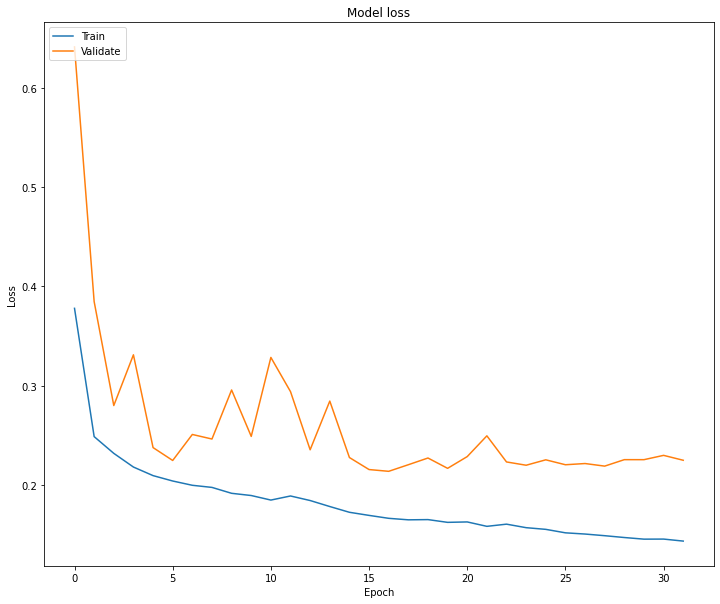

In [85]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,10))
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

In [86]:
#e_val = model.evaluate(test_gen)
e_val = model.evaluate(test_set)
print(f'IOU Score : {e_val[1]:.2f} F1-Score : {e_val[2]:.2f}')

19/19 [==============================] - 16s 815ms/step - loss: 0.2404 - iou_score: 0.6919 - f1-score: 0.8095 - precision: 0.7988 - recall: 0.8101
IOU Score : 0.69 F1-Score : 0.81


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


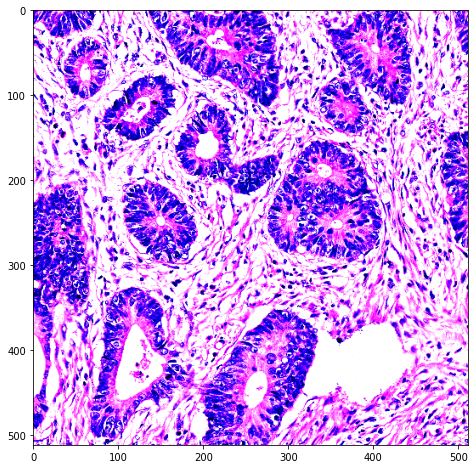

In [87]:
it = iter(test_set)
batch_x, batch_y = next(it)
for i in range(2):
    plt.imshow(batch_x[i])

In [ ]:
def vis_pred(img,mask):
    ''' img and mask has shape (-1,512,512,3) '''
    
    

In [90]:
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

In [1]:
idx = 27
t = model.predict(np.expand_dims(batch_x[idx],0))
plt.subplot(1,6,1);plt.title('image');plt.imshow(np.array(batch_x[idx]))
#plt.subplot(1,6,2);plt.title('mask');plt.imshow(np.argmax(batch_y[idx],axis=-1),vmin=0,vmax = 2)
plt.subplot(1,6,2);plt.title('mask');plt.imshow(np.array(batch_y[idx]).squeeze())
#plt.subplot(1,6,3);plt.title('tumor_prob');plt.imshow(np.squeeze(t[...,0]))
plt.subplot(1,6,3);plt.title('tumor_prob');plt.imshow(t[...,0].squeeze())
plt.subplot(1,6,4);plt.title('nerve_prob');plt.imshow(np.squeeze(t[...,1]))
plt.subplot(1,6,5);plt.title('backgr_prob');plt.imshow(np.squeeze(t[...,2]))
#plt.subplot(1,6,6);plt.title('mask');plt.imshow(np.squeeze(np.argmax(t,axis=-1)),vmin=0,vmax=2)
plt.subplot(1,6,6);plt.title('pred_mask');plt.imshow(np.array(t).squeeze(),vmin=0,vmax=2)

NameError: name 'model' is not defined

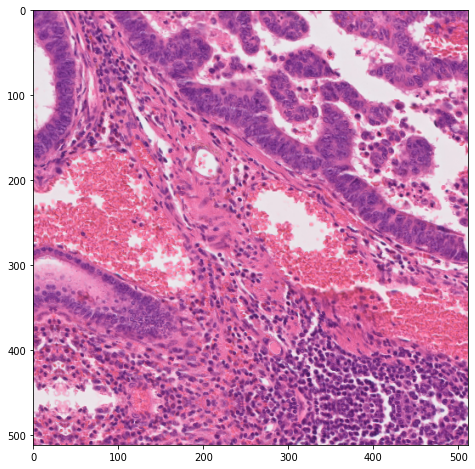

In [ ]:
def pred_multi(img_input):
    

In [ ]:
#model2 = build_seg_model(model='unet',backbone='inceptionv3',weight = WEIGHT,input_shape=INPUT_SHAPE,n_classes=N_CLASSES,loss=LOSS,init_lr=INITIAL_LEARNING_RATE,optimizer=OPTIMIZER,)
#model = sm.Deeplabv3(backbone='xception',classes=N_CLASSES,activation=ACTIVATION)
#model.load_weights('./model/0830_deeplab_xception_ish_nerve.hdf5')
model2 = sm.Deeplabv3('pascal_voc',input_shape = INPUT_SHAPE,backbone='xception',classes=1)
model2.load_weights('./model/deeplab_xception_pascal_voc_0910.hdf5')
model3 = sm.Unet('efficientnetb0',input_shape = INPUT_SHAPE)
model3.load_weights('./model/unet_efficientnetb0_imagenet_0911.hdf5')
model4 = sm.Unet('efficientnetb3',input_shape=INPUT_SHAPE)
model4.load_weights('./model/unet_efficientnetb3_imagenet_0910.hdf5')

In [ ]:
import numpy as np
batch_x,batch_y=  next(iter(test_set))
for i in range(0,10):

    img,msk = batch_x[i],batch_y[i]
    img = np.expand_dims(img,axis=0)
    pr_msk = model.predict(img)
    pr_msk = np.where(np.squeeze(pr_msk)>0.5,1,0)
    pr_msk_2 = model2.predict(img)
    pr_msk_2 = np.where(np.squeeze(pr_msk_2)>0.5,1,0)
    pr_msk_3 = model3.predict(img)
    pr_msk_3 = np.where(np.squeeze(pr_msk_3)>0.5,1,0)
    pr_msk_4 = model4.predict(img)
    pr_msk_4 = np.where(np.squeeze(pr_msk_4)>0.5,1,0)
    plt.figure(figsize = (14,10))
    plt.subplot(1,6,1); plt.title('deeplabv3 -lv4'); plt.imshow(pr_msk)
    plt.subplot(1,6,2); plt.title('deeplabv3 -lv5'); plt.imshow(pr_msk_2)
    plt.subplot(1,6,3); plt.title('unet_eff0'); plt.imshow(pr_msk_3)
    plt.subplot(1,6,4); plt.title('unet_eff3'); plt.imshow(pr_msk_4)
    plt.subplot(1,6,5); plt.title('true_mask'); plt.imshow(np.squeeze(batch_y[i]))
    plt.subplot(1,6,6); plt.title('true_img'); plt.imshow(np.squeeze((255*img).astype(np.uint8)))

#pr_msk = np.expand_dims(pr_msk,axis=-1)


---

## CROSS VALIDATION

In [ ]:
# Iterator로부터 create dataset
test_set = tf.data.Dataset.from_generator(
    file_gen,
    tf.string, 
    output_shapes = tf.TensorShape([None]),
    args = (TEST_ZIP,)
)
# dataset을 img load func에 mapping
test_set = test_set.map(lambda input_paths : tf.numpy_function(
    test_map_func,
    [input_paths],
    [tf.float32,tf.float32]
),num_parallel_calls=tf.data.experimental.AUTOTUNE)
# batch size
test_set = test_set.batch(BATCH_SIZE,drop_remainder=True)
# buffer
test_set = test_set.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

In [ ]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=4,shuffle=True,random_state=311)
train_val_slides = TRAIN_SLIDE_PATHS + VALID_SLIDE_PATHS
n_fold = 0
for x in kfold.split(train_val_slides):
    train_idxs = x[0]; val_idxs = x[1]
    train_slides = []; val_slides = []; train_zip = []; val_zip = []
    
    for i,j in enumerate(train_val_slides):
        if i in train_idxs:
            train_slides.append(train_val_slides[i])
        else:
            val_slides.append(train_val_slides[i])
    
    for path in train_slides:
        slide_name = path.split('/')[-1].replace('.tiff','').replace('svs','')
        patient_path = '/'.join(path.split('/')[:-1]) + '/'
        for lbl in TRUE_LABEL_LIST :
            target_list = glob.glob(patient_path+f'{PATCH_NAME}/mask/{slide_name}*_p{lbl["label"]}.png')
            train_zip.extend(target_list) 
        for lbl in ZERO_LABEL_LIST :
            target_list = glob.glob(patient_path+f'{PATCH_NAME}/mask/{slide_name}*_p{lbl["label"]}.png')
            train_zip.extend(shuffle(target_list,random_state = 311)[:lbl["restrict"]])
    train_zip = shuffle([('/'.join(x.split('/')[:-2])+'/image/'+re.sub('_p[0-9]','',x.split('/')[-1]),x) for x in train_zip],random_state=311)
    
    for path in val_slides:
        slide_name = path.split('/')[-1].replace('.tiff','').replace('svs','')
        patient_path = '/'.join(path.split('/')[:-1]) + '/'
        for lbl in TRUE_LABEL_LIST :
            target_list = glob.glob(patient_path+f'{PATCH_NAME}/mask/{slide_name}*_p{lbl["label"]}.png')
            val_zip.extend(target_list) 
        for lbl in ZERO_LABEL_LIST :
            target_list = glob.glob(patient_path+f'{PATCH_NAME}/mask/{slide_name}*_p{lbl["label"]}.png')
            val_zip.extend(shuffle(target_list,random_state = 311)[:lbl["restrict"]])
    val_zip = shuffle([('/'.join(x.split('/')[:-2])+'/image/'+re.sub('_p[0-9]','',x.split('/')[-1]),x) for x in val_zip],random_state=311)

    # Iterator로부터 create dataset
    train_set = tf.data.Dataset.from_generator(
        file_gen,
        tf.string, 
        output_shapes = tf.TensorShape([None]),
        args = (train_zip,)
    )
    # dataset을 img load func에 mapping
    train_set = train_set.map(lambda input_paths : tf.numpy_function(
        train_map_func,
        [input_paths],
        [tf.float32,tf.float32]
    ),num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # batch size
    train_set = train_set.batch(BATCH_SIZE,drop_remainder=True)
    # buffer
    train_set = train_set.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

    # Iterator로부터 create dataset
    valid_set = tf.data.Dataset.from_generator(
        file_gen,
        tf.string, 
        output_shapes = tf.TensorShape([None]),
        args = (val_zip,)
    )
    # dataset을 img load func에 mapping
    valid_set = valid_set.map(lambda input_paths : tf.numpy_function(
        test_map_func,
        [input_paths],
        [tf.float32,tf.float32]
    ),num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # batch size
    valid_set = valid_set.batch(BATCH_SIZE,drop_remainder=True)
    # buffer
    valid_set = valid_set.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

    # ---------------- 
    
    # Train
    # ----------------
    MODEL = 'unet'
    TODAY = datetime.datetime.now().strftime('%m%d')
    BACKBONE = 'efficientnetb0'
    WEIGHT = 'imagenet'
    LOSS = 'focal_dice'
    N_CLASSES = 1

    MODEL_PATH = os.path.join('./model/',(CLASS_NAME+'_'+str(MAGNIFICATION)+'_'+MODEL+'_'+BACKBONE+'_'+WEIGHT+'_'+TODAY +str(n_fold) +'.hdf5'))
    print(MODEL_PATH)
    
    # Loss, Optim, Metric
    dice_loss = sm.losses.DiceLoss()
    focal_loss = sm.losses.BinaryFocalLoss(alpha=0.25, gamma=6.0)
    loss = dice_loss + focal_loss
    optim = Adam(INITIAL_LEARNING_RATE)
    metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
    
    ## MULTIGPU
    import tensorflow as tf
    strategy = tf.distribute.MirroredStrategy()
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
    with strategy.scope():
        model = build_seg_model(model = MODEL,backbone=BACKBONE,weight = WEIGHT,input_shape=INPUT_SHAPE,n_classes=N_CLASSES)
        #model = sm.Deeplabv3(weights = WEIGHT,input_shape=INPUT_SHAPE,classes = N_CLASSES,activation=ACTIVATION,backbone=BACKBONE)
        #model = sm.Unet(BACKBONE, input_shape = INPUT_SHAPE,classes=N_CLASSES, activation=ACTIVATION,encoder_weights=WEIGHT,encoder_freeze=True)
        model.compile(optim, loss, metrics)
        
    class LossAndErrorPrintingCallback(tf.keras.callbacks.Callback):
        def on_train_batch_end(self, batch, logs=None):
            print("For batch {}, tr_loss is {:7.2f}.".format(batch, logs["loss"]))

        def on_test_batch_end(self, batch, logs=None):
            print("For batch {}, vl_loss is {:7.2f}.".format(batch, logs["loss"]))

        def on_epoch_end(self, epoch, logs=None):
            print(
                "The average loss for epoch {} is {:7.2f} "
                .format(
                    epoch, logs["loss"]
                )
            )

    #model.compile(optim, loss, metrics)
    callback_list = build_callback(MODEL_PATH,PATIENCE)
    callback_list.append(LossAndErrorPrintingCallback())
    
    # Train Model
    try:
        model.fit(train_set, 
                  epochs = EPOCHS,
                  batch_size=BATCH_SIZE,
                  validation_data=valid_set,
                  callbacks=callback_list,
                  max_queue_size=36,
                  workers=12,
                  #use_multiprocessing=True,
                  #verbose=1
                 )    
    except:
        pass
    
    model.evaluate(test_set)
    n_fold+=1

In [ ]:
model0 = build_seg_model('deeplab')
model1 = build_seg_model('deeplab')
model2 = build_seg_model('deeplab')
model3 = build_seg_model('deeplab')
model4 = build_seg_model('deeplab')
model0.load_weights('./model/tumor_50_deeplab_xception_pascal_voc_09280.hdf5')
model1.load_weights('./model/tumor_50_deeplab_xception_pascal_voc_09281.hdf5')
model2.load_weights('./model/tumor_50_deeplab_xception_pascal_voc_09282.hdf5')
model3.load_weights('./model/tumor_50_deeplab_xception_pascal_voc_09283.hdf5')
model4.load_weights('./model/tumor_50_deeplab_xception_pascal_voc_09284.hdf5')


In [ ]:
model0 = build_seg_model('unet',backbone='efficientnetb0',weight = 'imagenet',n_classes = 1)
model1 = build_seg_model('unet',backbone='efficientnetb0',weight = 'imagenet',n_classes = 1)
model2 = build_seg_model('unet',backbone='efficientnetb0',weight = 'imagenet',n_classes = 1)
model3 = build_seg_model('unet',backbone='efficientnetb0',weight = 'imagenet',n_classes = 1)
model4 = build_seg_model('unet',backbone='efficientnetb0',weight = 'imagenet',n_classes = 1)
model0.load_weights('./model/tumor_50_unet_efficientnetb0_imagenet_09290.hdf5')
model1.load_weights('./model/tumor_50_unet_efficientnetb0_imagenet_09291.hdf5')
model2.load_weights('./model/tumor_50_unet_efficientnetb0_imagenet_09292.hdf5')
model3.load_weights('./model/tumor_50_unet_efficientnetb0_imagenet_09293.hdf5')
model4.load_weights('./model/tumor_50_unet_efficientnetb0_imagenet_09294.hdf5')


In [ ]:
model0.compile(optimizer=optim,loss=loss,metrics=metrics)
eval_0 = model0.evaluate(test_set)
model1.compile(optimizer=optim,loss=loss,metrics=metrics)
eval_1 = model1.evaluate(test_set)
model2.compile(optimizer=optim,loss=loss,metrics=metrics)
eval_2 = model2.evaluate(test_set)
model3.compile(optimizer=optim,loss=loss,metrics=metrics)
eval_3 = model3.evaluate(test_set)
model4.compile(optimizer=optim,loss=loss,metrics=metrics)
eval_4 = model4.evaluate(test_set)

In [ ]:
print(eval_0)
print('')
print(eval_1)
print('')
print(eval_2)
print('')
print(eval_3)
print('')
print(eval_4)
print('')

In [ ]:
plt.imshow((pred_prob0 + pred_prob1 + pred_prob2 + pred_prob3 + pred_prob4) /5)

In [ ]:
batch_set = test_set.take(1)
for img_batch,msk_batch in batch_set:
    for i in range(20):
        img_input = np.expand_dims(img_batch[i],axis =0)
        pred_prob0 = np.squeeze(model0.predict(img_input))
        #pred_mask0 = np.logical_and(pred_prob>0.5,1)
        
        pred_prob1 = np.squeeze(model1.predict(img_input))
        #pred_mask1 = np.logical_and(pred_prob>0.5,1)
        
        pred_prob2 = np.squeeze(model2.predict(img_input))
        #pred_mask2 = np.logical_and(pred_prob>0.5,1)
        
        pred_prob3 = np.squeeze(model3.predict(img_input))
        #pred_mask3 = np.logical_and(pred_prob>0.5,1)
        
        pred_prob4 = np.squeeze(model4.predict(img_input))
        #pred_mask4 = np.logical_and(pred_prob>0.5,1)
        
        pred_prob_sum = (pred_prob0 + pred_prob1 + pred_prob2 + pred_prob3 + pred_prob4) /5
        pred_prob_sum_mask = np.logical_and(pred_prob_sum>0.5,1)
        plt.figure()
        plt.subplot(1,9,1); plt.title('img') ; plt.imshow(img_batch[i])
        plt.subplot(1,9,2); plt.title('msk') ; plt.imshow(msk_batch[i])
        plt.subplot(1,9,3); plt.title('pred0') ; plt.imshow(pred_prob0)
        plt.subplot(1,9,4); plt.title('pred1') ; plt.imshow(pred_prob1)
        plt.subplot(1,9,5); plt.title('pred2') ; plt.imshow(pred_prob2)
        plt.subplot(1,9,6); plt.title('pred3') ; plt.imshow(pred_prob3)
        plt.subplot(1,9,7); plt.title('pred4') ; plt.imshow(pred_prob4)
        plt.subplot(1,9,8); plt.title('pred_sum') ; plt.imshow(pred_prob_sum)
        plt.subplot(1,9,9); plt.title('pred_sum_mask') ; plt.imshow(pred_prob_sum_mask)

### KERA_TUNER

from kerastuner import Hyperband, HyperParameter, HyperParameters, HyperModel

def build_model(hp):
    dice_loss = sm.losses.DiceLoss()
    focal_loss = sm.losses.BinaryFocalLoss(alpha=0.25, gamma=6.0)
    total_loss = dice_loss + focal_loss
    metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
    
    BACKBONE = hp.Choice('backbone',['inceptionresnetv2','inceptionv3'])
    model = sm.Unet(BACKBONE,input_shape=(512,512,3),classes=1,activation='sigmoid',encoder_weights='imagenet')
    '''
    if hp.Choice('optimizer',['adam','sgd'])=='adam':
        model.compile(Adam(lr=hp.Choice('learning_rate',[1e-3,1e-4,1e-5])),total_loss,metrics)
    else:
        model.compile(SGD(lr=hp.Choice('learning_rate',[1e-3,1e-4,1e-5])),total_loss,metrics)
    '''
    model.compile(optimizer = Adam(hp.Float('learning_rate',1e-4,1e-2,sampling='log')),loss=total_loss,metrics=metrics)
    return model
    
## CALLBACK
model_path='./data/model/seg_tumor_0718.hdf5'
mc = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
es = EarlyStopping(monitor = 'val_loss',patience = 4)
lr = ReduceLROnPlateau(
    monitor='val_loss',  # 검증 손실을 기준으로 callback이 호출됩니다
    factor=0.5,          # callback 호출시 학습률을 1/2로 줄입니다
    patience=2,         # epoch 4 동안 개선되지 않으면 callback이 호출됩니다
)
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)
callbacks_list = [mc,es,lr,ClearTrainingOutput()]

tuner = Hyperband(
    hypermodel=build_model,
    objective="val_loss",
    max_epochs=10,
    factor=3,
    hyperband_iterations=1,
    distribution_strategy=tf.distribute.MirroredStrategy(),
    directory='tumor_segmentation'
)

tuner.search(
    train_gen, 
    validation_data=valid_gen, 
    epochs=10,
    callbacks = callbacks_list
)

tuner.results_summary()

best_hp = tuner.get_best_hyperparameters()[0]

best_hp.values

best_model = tuner.hypermodel.build(best_hp)

model_path = './data/model/seg_tumor_tuner_inceptionv3.hdf5'
mc = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
es = EarlyStopping(monitor = 'val_loss',patience = 8)
lr = ReduceLROnPlateau(
    monitor='val_loss',  # 검증 손실을 기준으로 callback이 호출됩니다
    factor=0.5,          # callback 호출시 학습률을 1/2로 줄입니다
    patience=4,         # epoch 4 동안 개선되지 않으면 callback이 호출됩니다
)
callbacks_list = [mc,es,lr]

history = best_model.fit(
    train_gen,
    validation_data = valid_gen,
    callbacks = callbacks_list,
    epochs=EPOCHS,
    max_queue_size=15,
    use_multiprocessing=True,
    verbose=1
)
best_model.evaluate(test_gen)